# The AML network based on Figure 3 in the Palma paper
### This simulation will focus on BCL2 inhibition and the effects on the scores of individual patients

### Importing the BMatrix, BooleanNetwork, and clinical data

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import booleanNetwork module from ./src
import sys
sys.path.append('src/BNMPy')
import booleanNetwork as bn
import BMatrix  

In [15]:
# s7_data_combined has all the patient's mutation profiles
s5_df = pd.read_excel("C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/raw_data/s5_table.xlsx")

s7_df = pd.read_excel("C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/raw_data/python_s7.xlsx")
mutation_profiles = s7_df['mutation_profiles'].values.reshape(-1, 1)
#print(mutation_profiles)

### Preparing variables for simulation + calculation

In [16]:
file = 'C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/BN_equations/fig3_AML_equations.txt'

equations = BMatrix.getting_equations(file)
gene_dict = BMatrix.gene_dictionary(equations)
only_genes = BMatrix.getting_only_genes(equations)

varF = BMatrix.connectivity_matrix(equations,only_genes,gene_dict)
varF = np.array(varF)
#print(varF)

F = BMatrix.extracting_truth_table(equations,only_genes)
F = np.array(F)
#print(F)

# initial state
x0 = np.random.randint(2, size=ngenes) #random inital state 
x0 = np.array(x0)
#print(x0)

ngenes= len(equations)

In [17]:
file_equations = 'C:/Users/15167/OneDrive/Documents/ISB/AML-DT-BNM/BN_equations/fig3_calculating_equations.txt'

cal_equations = BMatrix.getting_equations(file_equations)
cal_functions = BMatrix.calculating_functions(cal_equations)
cal_only_genes = BMatrix.calculating_only_genes(cal_equations)

### Testing to see how long it runs + convergence

In [18]:
%%time

network = bn.BooleanNetwork( ngenes , varF, F, x0  ) # create a Boolean network object
noise_level = 0.05 # noise
y = network.update_noise ( noise_level  , 200000) # simulation with noise

CPU times: total: 37.8 s
Wall time: 37.8 s


In [19]:
%%time

y_range = y #all of the y values (for relative error plot)
scores_dict,final_score = BMatrix.calculating_scores(y, cal_functions, cal_only_genes, gene_dict, y_range)

CPU times: total: 36.3 s
Wall time: 36.3 s


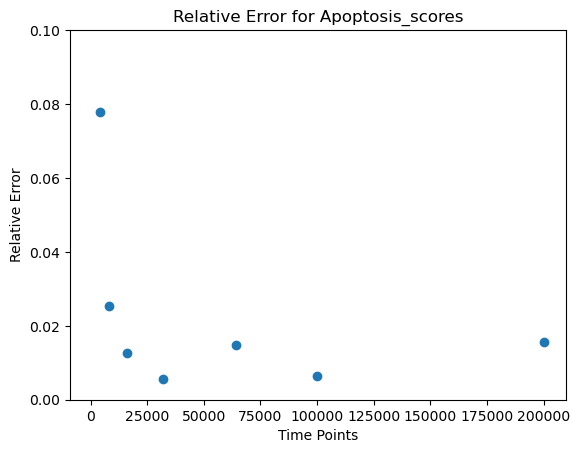

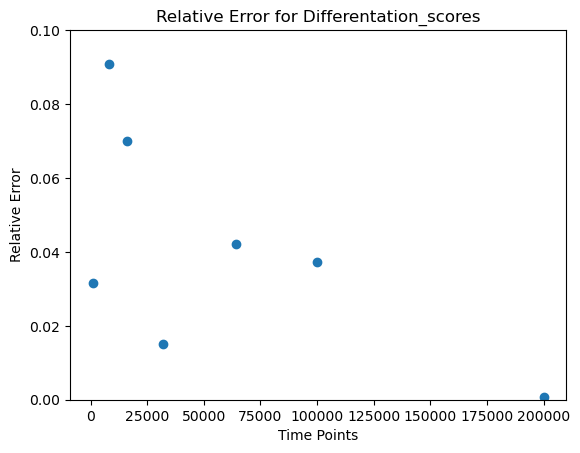

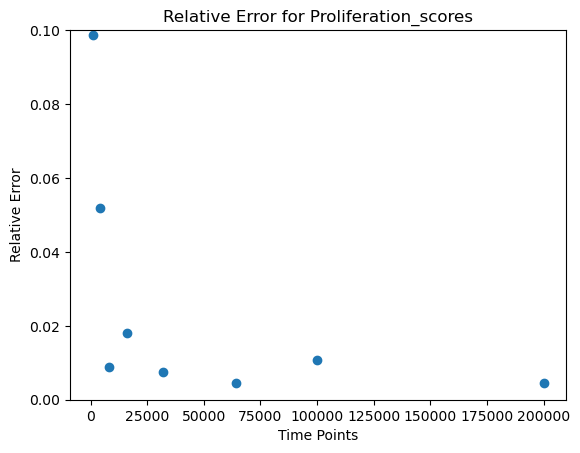

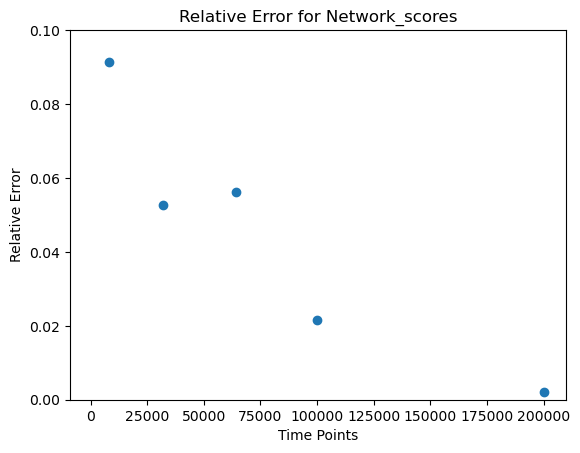

In [20]:
#getting the relative error points to see if the score converges
Apoptosis_scores = scores_dict['Apoptosis']
Differentiation_scores = scores_dict['Differentiation']
Proliferation_scores = scores_dict['Proliferation']
Network_scores = scores_dict['Network']

scores = [Apoptosis_scores, Differentiation_scores, Proliferation_scores, Network_scores]
time_points = [1000, 2000, 4000, 8000, 16000, 32000, 64000, 100000, 200000]

plot_title = {0:'Apoptosis_scores',
              1:'Differentation_scores',
              2: 'Proliferation_scores',
              3: 'Network_scores'}

#print(plot_title)
#print(time_points)

for i in range(len(scores)): #for apop, diff, prolif, or final
    values = [] 
    relative_error = [] #reset the values
    score = scores[i]
    
    title = plot_title[i]
    #print(title)
    
    for i in range(len(time_points)): #for all time points
        point = time_points[i]
        half = (time_points[i])//2
        start_index = slice(0,half) #so for i=1, this is 1:500
        end_index = slice(half,point) #if i=1, this is 500:1000
        
        point = (abs((np.mean(score[start_index])) - (np.mean(score[end_index]))))/(np.mean(score[start_index]))
        
        values.append(point)
    
    relative_error = [np.round(value, decimals=4) for value in values]
    #print(relative_error)  
    
    plot = pd.DataFrame({'time_points': time_points, 'relative_error': relative_error})
    plt.scatter(plot['time_points'], plot['relative_error'])
    plt.xlabel('Time Points')
    plt.ylabel('Relative Error')
    plt.title('Relative Error for ' + title)
    plt.ylim(0, 0.1)
    plt.show()